In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

# NOTE: WE ASSUME LINEAR RELATIONSHIP WE LINEAR REGRESSION

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.cascade_property_vectorizer import get_vector_from_string

In [3]:
# Set parameters
file_path = "./data/no_padding/single/single-data-1732743578421047000.csv"
chunk_size = 1000
test_size = 0.2
random_state = 42

In [4]:
# Initialize lists for collecting data 
X_all = [] 
y_all = []  

# Read and process data in chunks 
print("Reading and processing data...") 
for chunk in pd.read_csv(file_path, chunksize=chunk_size, delimiter=";"):     
    X_chunk = np.array([get_vector_from_string(row)                         
                    for row in chunk['concatenated_bitstrings']]) 
    print(X_chunk.shape)
    
    y_chunk = chunk['num_included'].values
    
    X_all.append(X_chunk)
    y_all.append(y_chunk)

Reading and processing data...
(1000, 9)


In [5]:
chunk.head()

,concatenated_bitstrings,num_included,num_excluded,duration,tries
0,6SUUkiAnArsLdiygw3TmEgeIi8WeyRxjv-jRtlTqFiCu5q...,37121,50000,0.636110,1
1,dG84Cq77Rb6YHZkSRz8xxz7_f9N1kfpmm-5-WkfExhs653...,39731,50000,0.682093,1
2,PCL6MREqHroBmMHFUJBPIA4hKsUMFa5hguDMtLh71hYZ0M...,30417,50000,0.590033,1
3,31uejo064P9SaayKvej3TxIrYnjOGuZSKzPRrS64s3n-1B...,34885,50000,0.511412,1
4,u0JH2Z6BHkcZQW5geHAevz9KMhev4iAAAhBBHh9NXUbv-m...,40989,50000,0.615572,1


In [6]:
# testing stuff
chunk['filter_one_length'] = chunk['concatenated_bitstrings'].str.split(',').str[0].str.len()
chunk['filter_two_length'] = chunk['concatenated_bitstrings'].str.split(',').str[1].str.len()
chunk['one_two_ratio'] = chunk['filter_one_length'] / chunk['filter_two_length']

# Display first few rows to verify
print("\nFirst few rows:")
print(chunk[['filter_one_length', 'filter_two_length', 'one_two_ratio']].head())



First few rows:
   filter_one_length  filter_two_length  one_two_ratio
0               8904               5228       1.703137
1               7756               6956       1.115009
2               9008               4832       1.864238
3               8300               6344       1.308323
4               8552               5948       1.437794


In [7]:
chunk.head()

,concatenated_bitstrings,num_included,num_excluded,duration,tries,filter_one_length,filter_two_length,one_two_ratio
0,6SUUkiAnArsLdiygw3TmEgeIi8WeyRxjv-jRtlTqFiCu5q...,37121,50000,0.636110,1,8904,5228,1.703137
1,dG84Cq77Rb6YHZkSRz8xxz7_f9N1kfpmm-5-WkfExhs653...,39731,50000,0.682093,1,7756,6956,1.115009
2,PCL6MREqHroBmMHFUJBPIA4hKsUMFa5hguDMtLh71hYZ0M...,30417,50000,0.590033,1,9008,4832,1.864238
3,31uejo064P9SaayKvej3TxIrYnjOGuZSKzPRrS64s3n-1B...,34885,50000,0.511412,1,8300,6344,1.308323
4,u0JH2Z6BHkcZQW5geHAevz9KMhev4iAAAhBBHh9NXUbv-m...,40989,50000,0.615572,1,8552,5948,1.437794


Text(0, 0.5, 'Count')

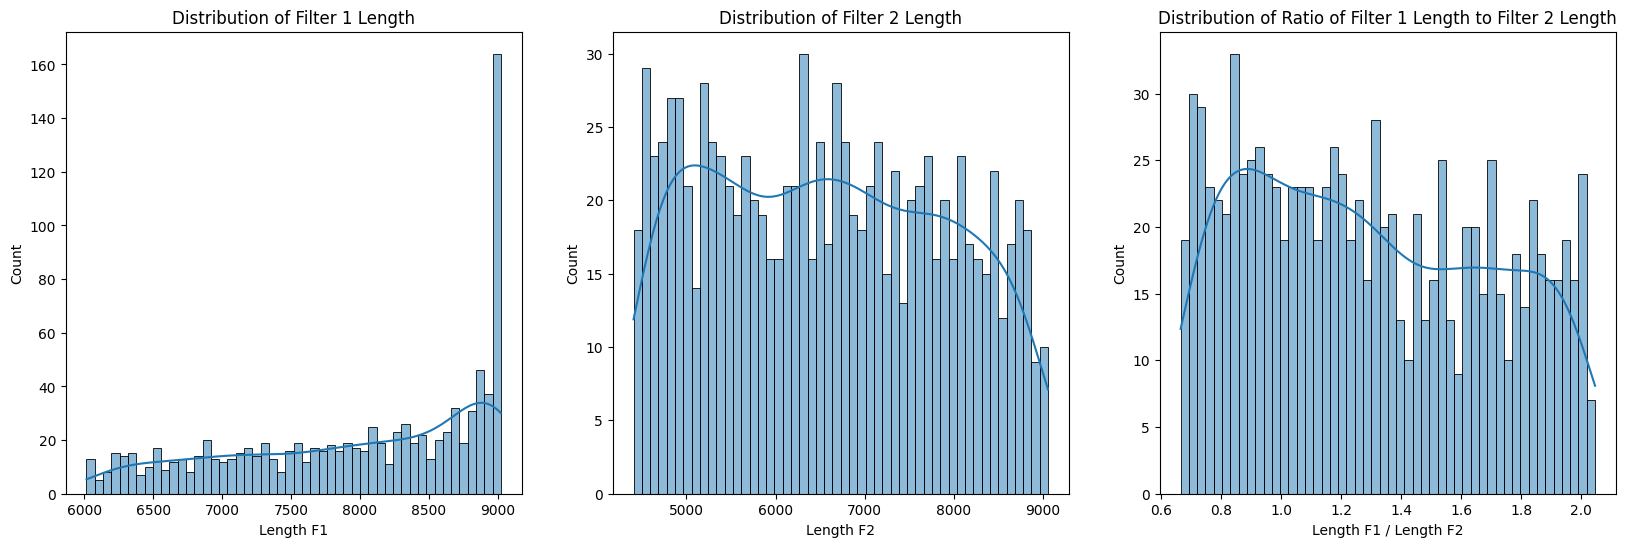

In [8]:
# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(data=chunk['filter_one_length'], bins=50, kde=True, ax=ax1)
ax1.set_title('Distribution of Filter 1 Length')
ax1.set_xlabel('Length F1')
ax1.set_ylabel('Count')

sns.histplot(data=chunk['filter_two_length'], bins=50, kde=True, ax=ax2)
ax2.set_title('Distribution of Filter 2 Length')
ax2.set_xlabel('Length F2')
ax2.set_ylabel('Count')

sns.histplot(data=chunk['one_two_ratio'], bins=50, kde=True, ax=ax3)
ax3.set_title('Distribution of Ratio of Filter 1 Length to Filter 2 Length')
ax3.set_xlabel('Length F1 / Length F2')
ax3.set_ylabel('Count')

<Figure size 2000x1000 with 0 Axes>

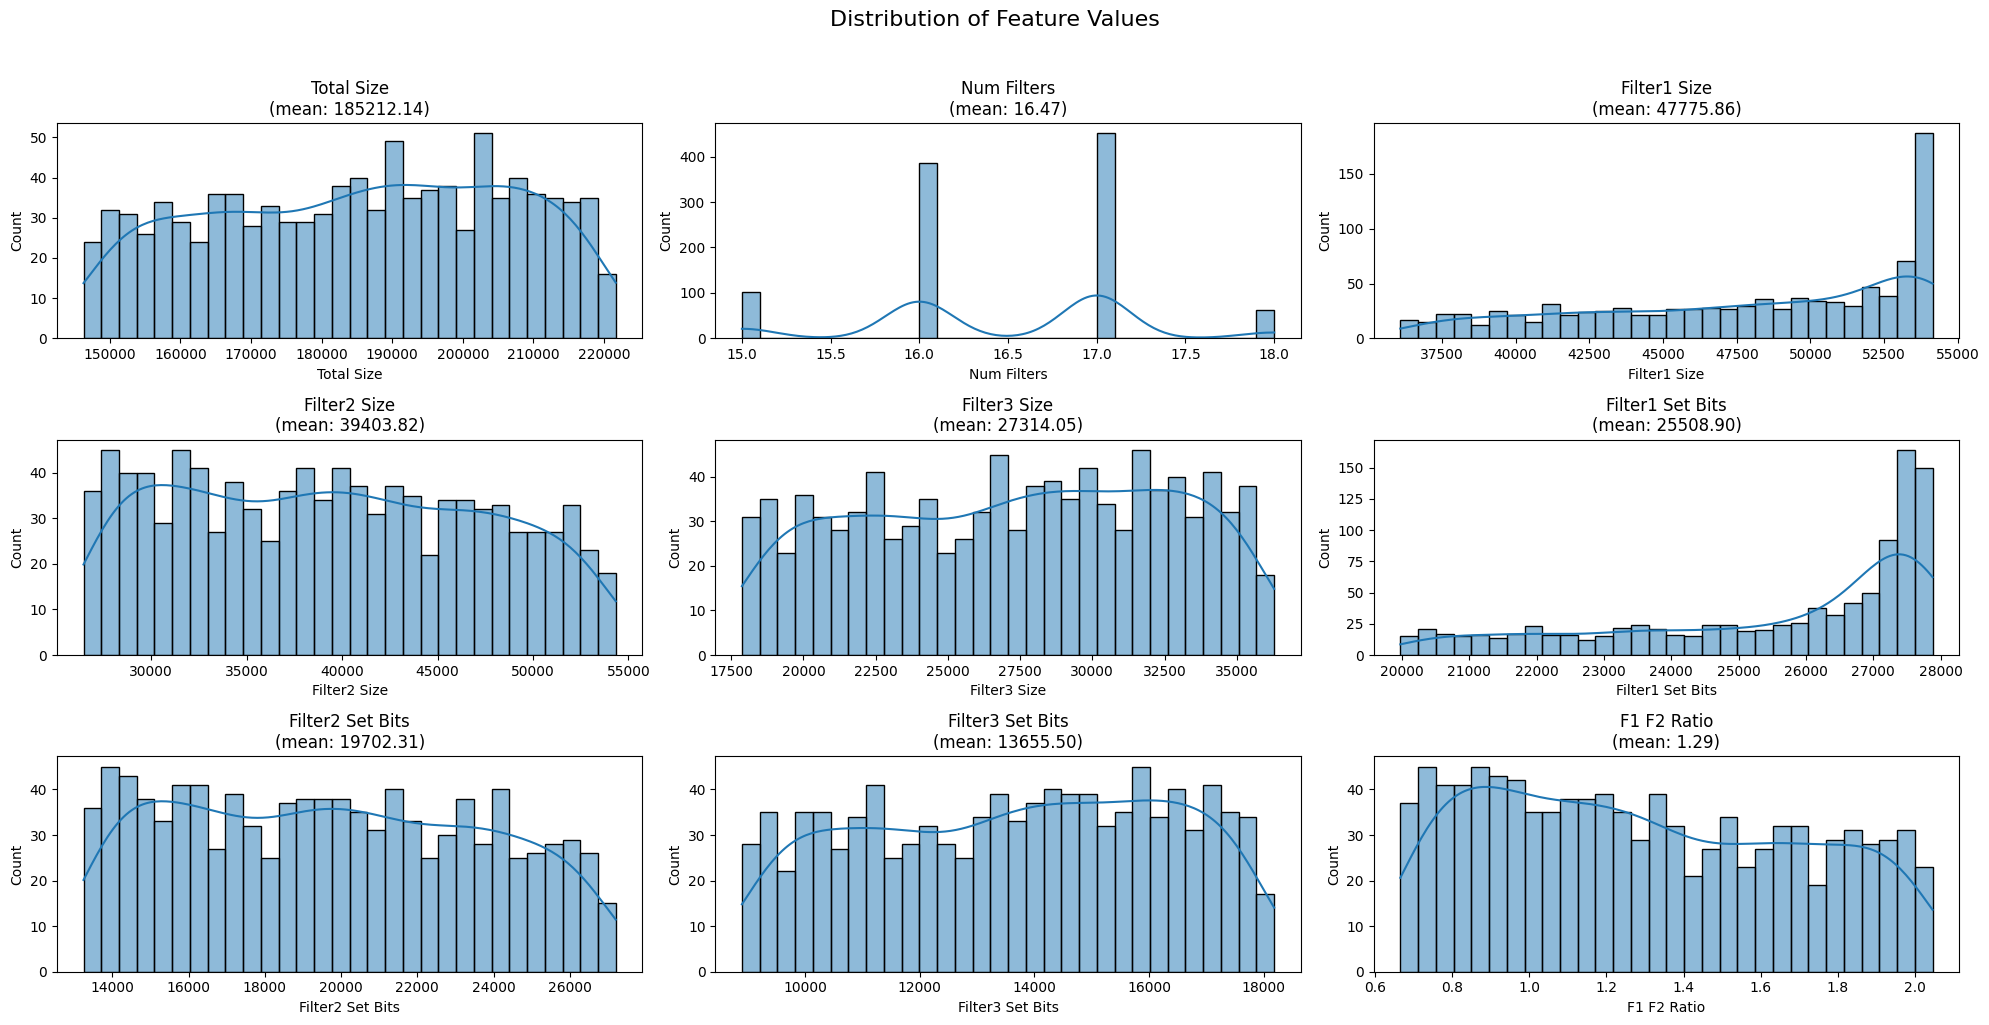

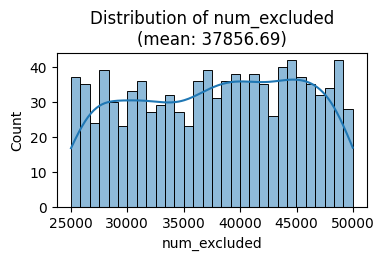

In [9]:
# Combine chunks into one array and create DataFrame
X = np.vstack(X_all)
y = np.concatenate(y_all)

feature_names = [
    'Total Size', 'Num Filters', 'Filter1 Size', 
    'Filter2 Size', 'Filter3 Size', 'Filter1 Set Bits',
    'Filter2 Set Bits', 'Filter3 Set Bits', 'F1 F2 Ratio'
]
df = pd.DataFrame(X, columns=feature_names)

# Plot features
plt.figure(figsize=(20, 10))
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.suptitle('Distribution of Feature Values', size=16, y=1.02)

for idx, (feature, ax) in enumerate(zip(feature_names, axes.ravel())):
    sns.histplot(data=df[feature], bins=30, ax=ax, kde=True)
    ax.set_title(f'{feature}\n(mean: {df[feature].mean():.2f})')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(data=np.concatenate(y_all), bins=30, kde=True)
plt.title(f'Distribution of num_excluded\n(mean: {np.mean(y):.2f})')
plt.xlabel('num_excluded')
plt.ylabel('Count')
plt.show()

<Figure size 2000x1500 with 0 Axes>

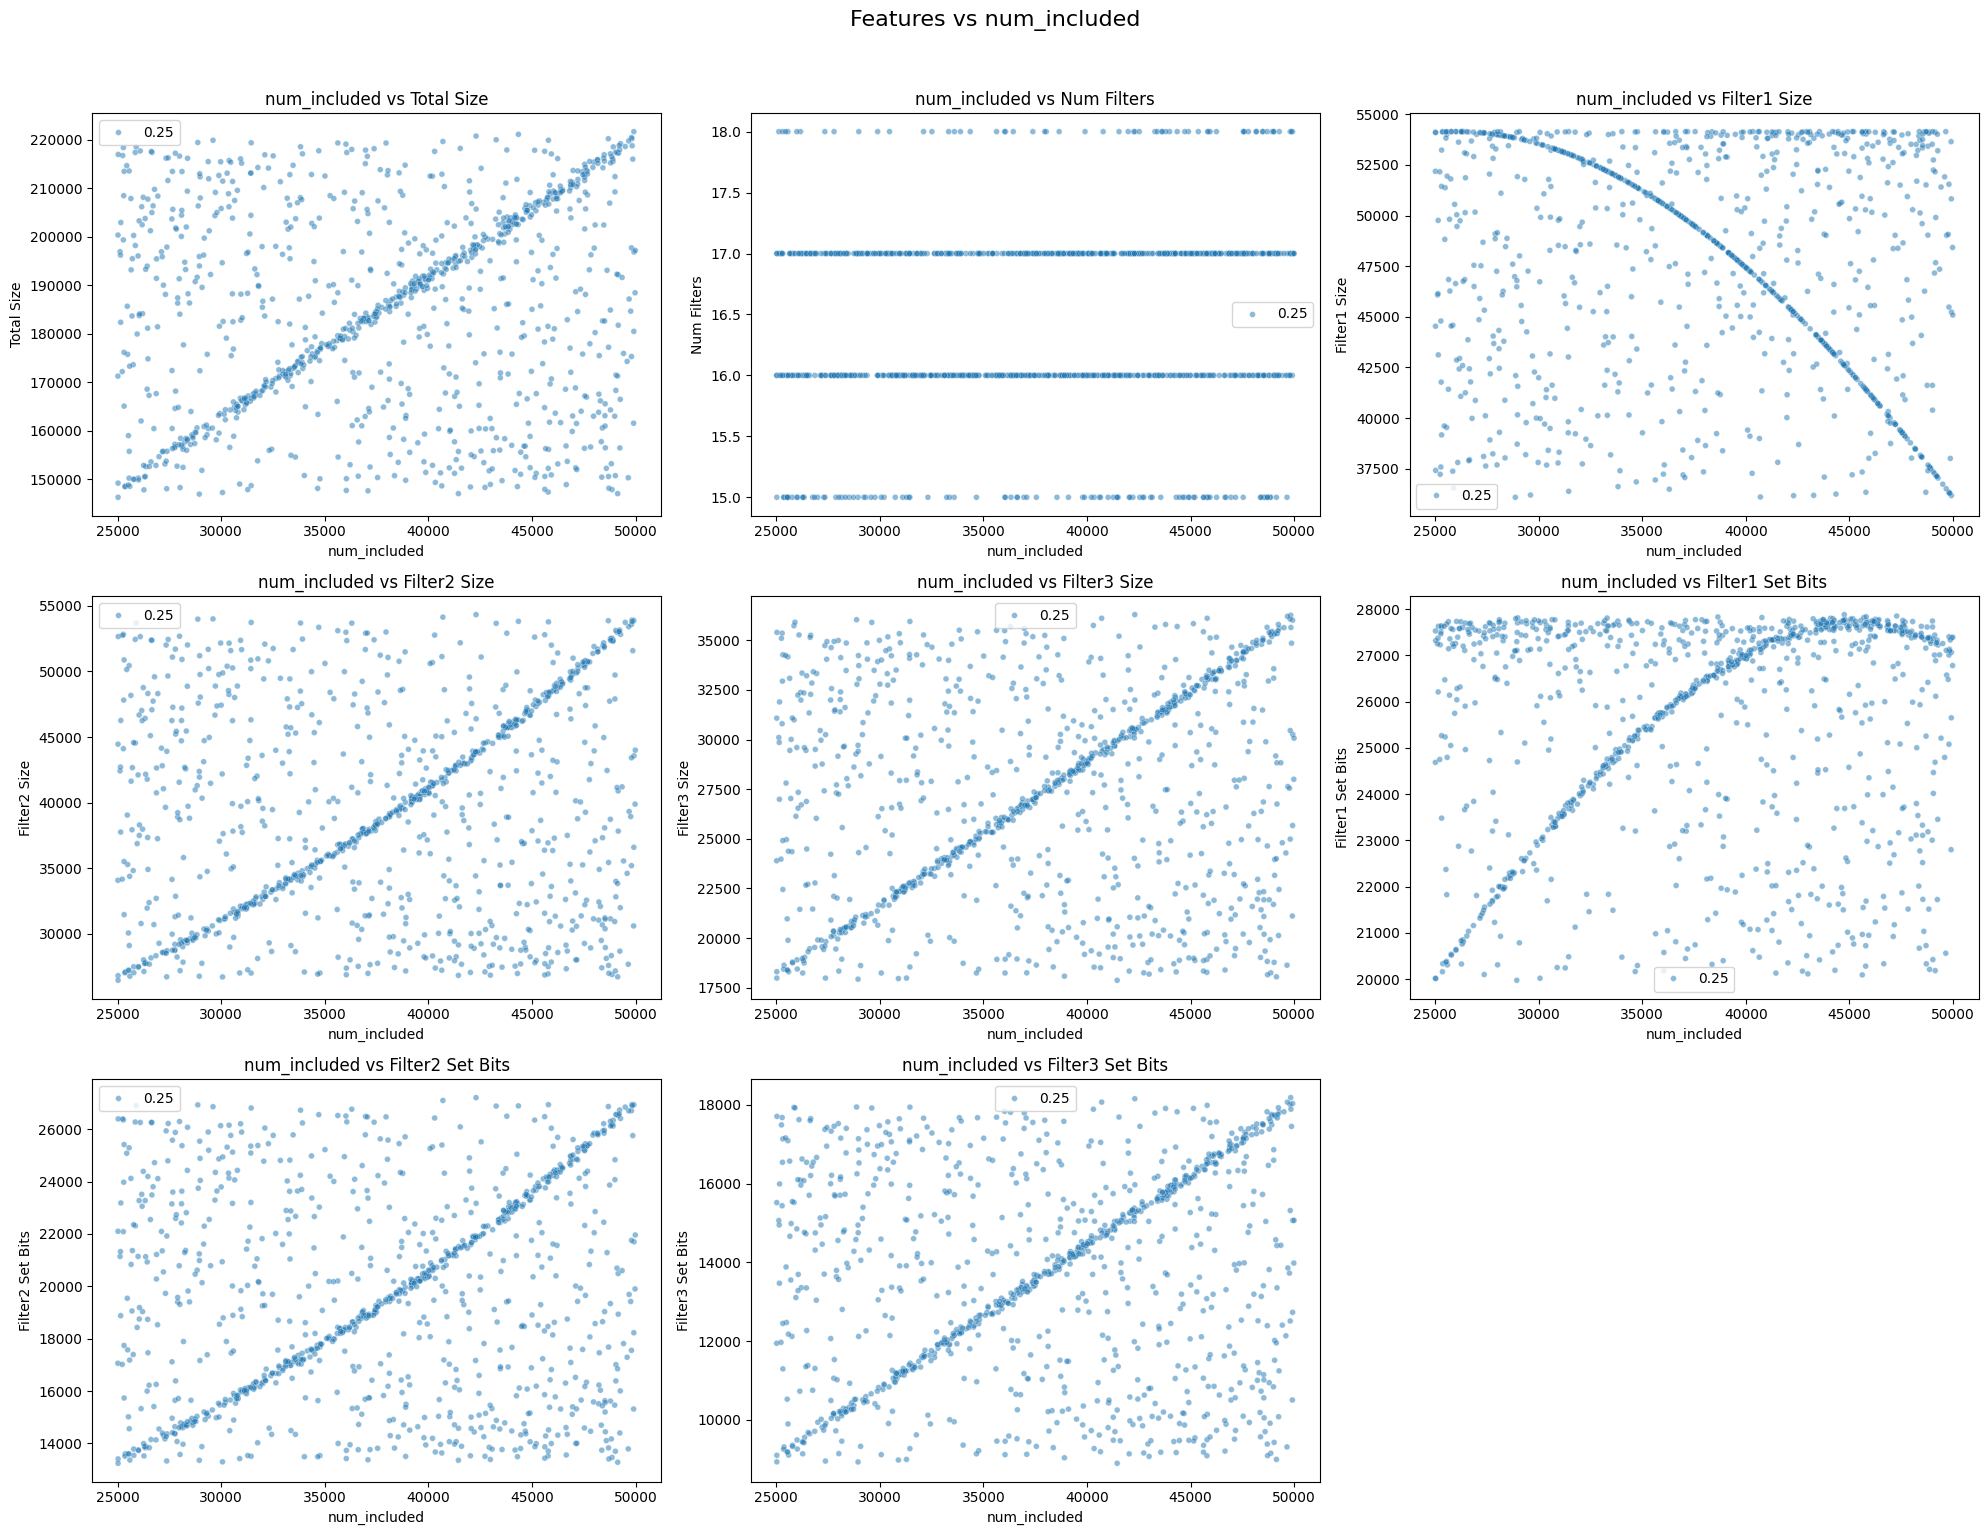

In [10]:
plt.figure(figsize=(20, 15))
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Features vs num_included', size=16, y=1.02)

# Flatten axes for easier iteration
axes = axes.ravel()

# Create scatter plot for each feature
for idx, feature in enumerate(feature_names):
    sns.scatterplot(
        data=df,
        x=y,
        y=feature,
        ax=axes[idx],
        alpha=0.5,
        size=0.25
    )
    axes[idx].set_title(f'num_included vs {feature}')
    axes[idx].set_xlabel('num_included')
    axes[idx].set_ylabel(feature)

# Remove the empty subplot (since we have 8 features and 9 subplots)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [11]:
# Combine all chunks
X = np.vstack(X_all)
y = np.concatenate(y_all)

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=test_size, random_state=random_state
)

Scaling features...
Splitting data...


In [12]:
# Train linear regression model
print("Training model...")
# model = Lasso(alpha=1.0)
# model = RandomForestRegressor()
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Training model...


Ridge()

In [13]:
# Make predictions
y_pred = model.predict(X_test)

In [14]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Model Performance Metrics:
Mean Squared Error: 51596168.53
R² Score: 0.00


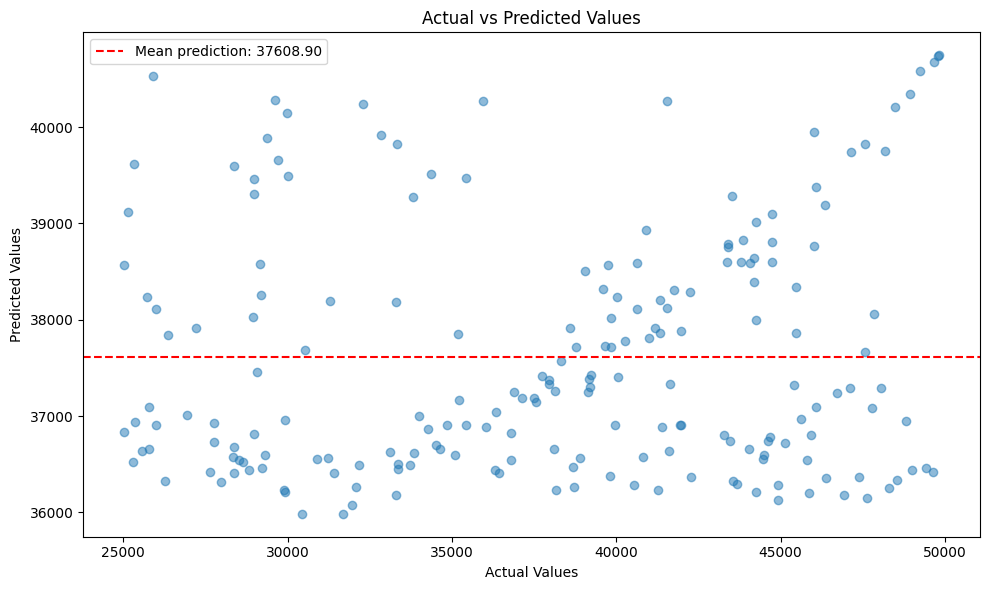

In [15]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.axhline(y=np.mean(y_pred), color='r', linestyle='--', label=f'Mean prediction: {np.mean(y_pred):.2f}')

# Set y-axis limits to the actual range of predictions
y_min, y_max = np.min(y_pred), np.max(y_pred)
plt.ylim(y_min - (y_max - y_min)*0.05, y_max + (y_max - y_min)*0.05)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Feature names
feature_names = [
    'Total Size', 'Num Filters', 'Filter1 Size', 
    'Filter2 Size', 'Filter3 Size', 'Filter1 Set Bits',
    'Filter2 Set Bits', 'Filter3 Set Bits', 'F1 F2 Ratio'
]

# Create coefficient analysis
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
})
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

# Print coefficients
print("\nFeature Coefficients (sorted by absolute value):")
for _, row in coefficients.iterrows():
    print(f"{row['Feature']}: {row['Coefficient']:.4f}")


Feature Coefficients (sorted by absolute value):
Filter3 Set Bits: 5397.1004
Total Size: -5094.8371
Filter1 Size: -2982.2257
Filter2 Size: -2463.0427
Filter3 Size: 389.0781
Num Filters: 254.5079
Filter1 Set Bits: 231.7770
Filter2 Set Bits: -228.9580
F1 F2 Ratio: 118.6865


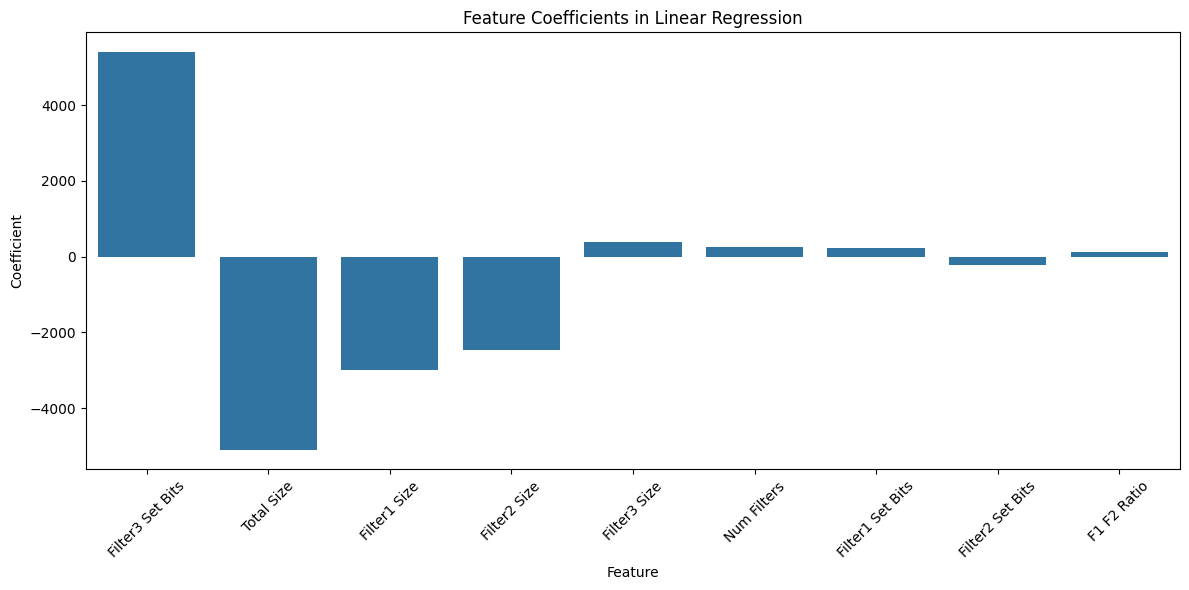

In [17]:
# Plot coefficients
plt.figure(figsize=(12, 6))
sns.barplot(data=coefficients, x='Feature', y='Coefficient')
plt.xticks(rotation=45)
plt.title('Feature Coefficients in Linear Regression')
plt.tight_layout()
plt.show()